In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import random
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
#绘制序列
def plot_series(time,series,format="-",start=0,end=None,label=None):
    #根据时间轴和对应数据列表绘制序列图像
    plt.plot(time[start:end],series[start:end],format,label=label)
    #设置横纵轴意义
    plt.xlabel("Time")
    plt.ylabel("Value")
    #设置图例说明字体大小
    if label:
        plt.legend(fontsize=14)
    #显示网络
    plt.grid(True)

In [3]:
#趋势模式
def trend(time,slope=0):
    #序列与时间呈线性关系
    return slope*time

In [4]:
#白噪声
def white_noise(time,noise_level=1,seed=None):
    #生成正态分布的伪随机数序列
    rnd=np.random.RandomState(seed)
    #noise_level控制噪声幅值大小
    return rnd.randn(len(time))*noise_level

In [5]:
#季节性（周期性）模式
def seasonal_pattern(season_time):
    """Just an arbitrary pattern,you can change it if you wish"""
    #分段函数（自变量取值[0，1]作为一个模式
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

#将某个季节性（周期性）模式循环多次
def seasonality(time,period,amplitude=1,phase=0):
    """Repeats the same pattern at each period"""
    #将时间映射到0-1之间
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

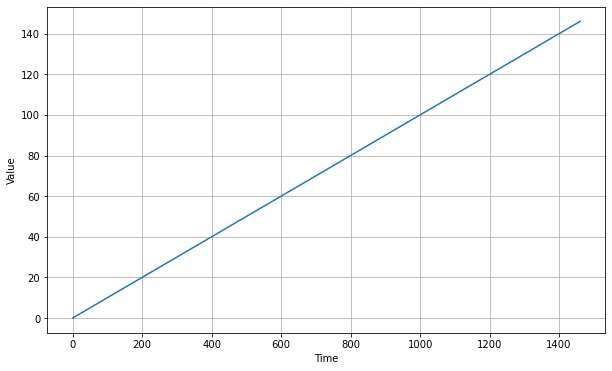

In [6]:
#时间
time=np.arange(4*365+1)
#只包含上升趋势的序列
series=trend(time,0.1)
#设置画布大小
plt.figure(figsize=(10,6))
#根据time series绘制序列
plot_series(time,series)
plt.show()

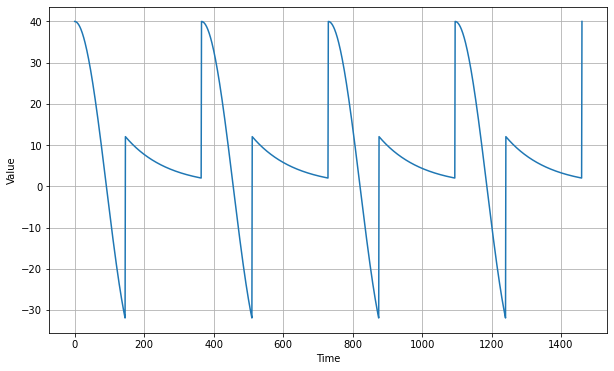

In [7]:
#设置季节性幅值
amplitude=40
#生成季节性序列
series=seasonality(time,period=365,amplitude=amplitude)
#绘制序列
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

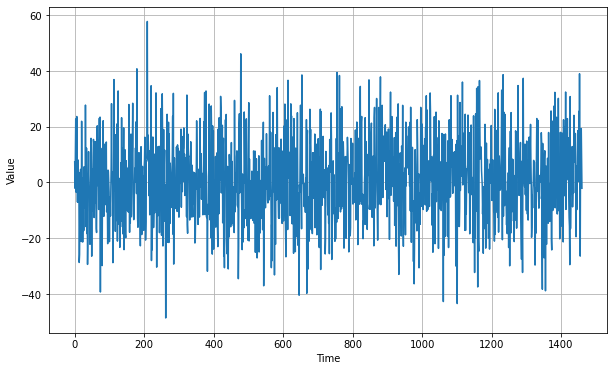

In [8]:
#设置噪声幅值
noise_level=15
#生成噪声序列
noise=white_noise(time,noise_level,seed=42)
#绘制序列
plt.figure(figsize=(10,6))
plot_series(time,noise)
plt.show

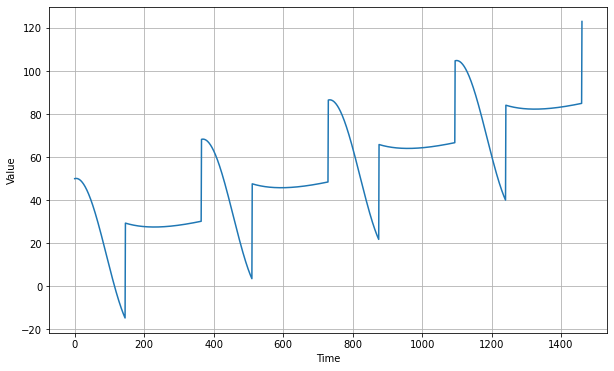

In [9]:
#基础序列+上升趋势+季节性
slope=0.05
baseline=10
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
#绘制序列
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

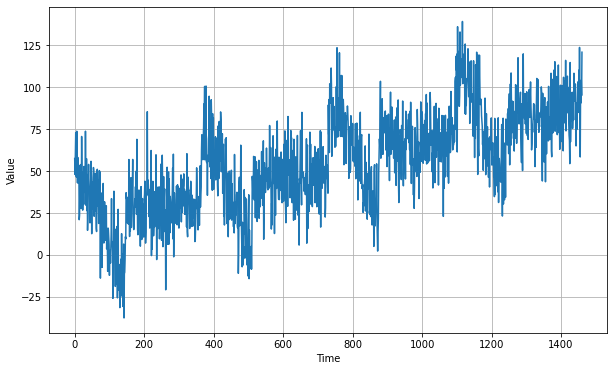

In [10]:
#基础序列+上升趋势+季节性+白噪声
series+=noise
#绘制序列
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [11]:
#制定比例，划分训练集和测试集
def train_test_split(series,split_prop):
    train=series[:int(split_prop*int(series.size))]
    test=series[int(split_prop*int(series.size)):]
    return train,test

In [12]:
def data_process(train,test,window_size):
    #将数据转为tensor并进行滑窗，得到短序列
    train_tensor=torch.from_numpy(train)
    train_window_split=train_tensor.unfold(0,window_size,1)
    train_set=train_window_split.numpy()
    
    test_tensor=torch.from_numpy(test)
    test_window_split=test_tensor.unfold(0,window_size,1)
    test_set=test_window_split.numpy()
    
    #将训练集短序列打乱
    train_temp1=train_set.tolist()
    random.shuffle(train_temp1)
    train_temp2=np.array(train_temp1)
    
    test_temp1 = test_set.tolist()
    random.shuffle(test_temp1)
    test_temp2 = np.array(test_temp1)
    
    #将短序列划分为feature label
    train_feature_array=train_temp2[:,:window_size-1]
    train_label_array=train_temp2[:,window_size-1:]
    test_feature_array=test_temp2[:,:window_size-1]
    test_label_array=test_temp2[:,window_size-1:]
    
    #将ndarray转为tensor
    train_feature=torch.from_numpy(train_feature_array)
    train_label_temp=torch.from_numpy(train_label_array)
    test_feature=torch.from_numpy(test_feature_array)
    test_label_temp=torch.from_numpy(test_label_array)
    
    #将label张量降维
    train_label=train_label_temp.squeeze()
    test_label=test_label_temp.squeeze()
    
    return train_feature,train_label,test_feature,test_label

In [13]:
#将数据划分为指定大小的batch
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    for i in range(0,num_examples,batch_size):
        #最后一次可能不足一个batch
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)

In [14]:
split_prop=0.7
train,test=train_test_split(series,split_prop)
window_size=6
train_feature,train_label,test_feature,test_label=data_process(train,test,window_size)
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([1017,5])
torch.Size([1017])
torch.Size([434,5])
torch.Size([434])

torch.Size([1017, 5])
torch.Size([1017])
torch.Size([434, 5])
torch.Size([434])


torch.Size([434])

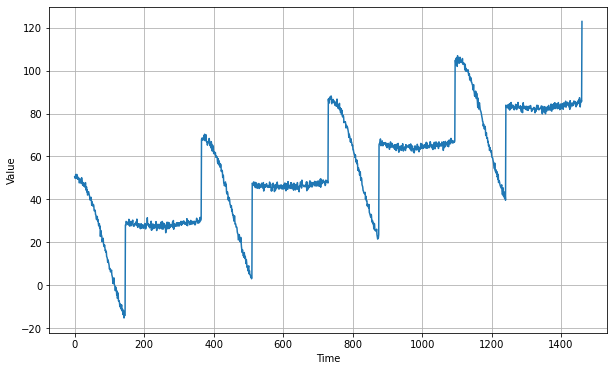

In [15]:
#生成序列并绘制图像
time=np.arange(4*365+1)
baseline=10
slope=0.05
amplitude=40
noise_level=1
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)+white_noise(time,noise_level,seed=42)

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [16]:
split_prop=0.7
train,test=train_test_split(series,split_prop)
window_size=6
train_feature,train_label,test_feature,test_label=data_process(train,test,window_size)
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([1017, 5])
torch.Size([1017])
torch.Size([434, 5])
torch.Size([434])


In [17]:
#实现FlattenLayer层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)
#定义模型输入、输出、隐藏层参数
num_inputs,num_outputs,num_hiddens=5,1,3

#定义模型
net=nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs,num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens,num_outputs),
    )

In [18]:
#损失函数
def squared_loss(y_hat,y):
    return(y_hat-y.view(y_hat.size()))**2/(y.shape[0])

In [19]:
#参数初始化
for params in net.parameters():
    torch.nn.init.normal_(params,mean=0,std=0.01)
    
lr=0.01 #学习率
num_epochs=200 #batch_size大小
loss=squared_loss #损失函数
optimizer=torch.optim.Adam(net.parameters(),lr) #设置优化器

In [25]:
train_loss=[]
test_loss=[]
batch_size=5

#模型训练
for epoch in range(num_epochs):#外循环训练一轮
    train_1,test_1=0.0,0.0
    for X,y in data_iter(batch_size,train_feature,train_label):#内循环训练一个batch
        y_hat=net(X) #计算模型输出
        l=loss(y_hat,y).sum() #计算模型输出与真实数据之间的差距
        
        #梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        #反向传播
        l.backward()
        optimizer.step()
    train_1=loss(net(train_feature),train_label)
    test_1=loss(net(test_feature),test_label)
    train_loss.append(train_1.mean().item())
    test_loss.append(test_1.mean().item())
    print('epoch %d,train loss %f,test loss %f'%(epoch+1,train_1.mean().item(),test_1.mean().item()))

epoch 1,train loss 0.011774,test loss 0.038488
epoch 2,train loss 0.011774,test loss 0.038487
epoch 3,train loss 0.011774,test loss 0.038487
epoch 4,train loss 0.011773,test loss 0.038486
epoch 5,train loss 0.011773,test loss 0.038485
epoch 6,train loss 0.011773,test loss 0.038484
epoch 7,train loss 0.011772,test loss 0.038484
epoch 8,train loss 0.011772,test loss 0.038483
epoch 9,train loss 0.011772,test loss 0.038482
epoch 10,train loss 0.011771,test loss 0.038481
epoch 11,train loss 0.011771,test loss 0.038481
epoch 12,train loss 0.011771,test loss 0.038480
epoch 13,train loss 0.011770,test loss 0.038479
epoch 14,train loss 0.011770,test loss 0.038479
epoch 15,train loss 0.011770,test loss 0.038478
epoch 16,train loss 0.011769,test loss 0.038477
epoch 17,train loss 0.011769,test loss 0.038477
epoch 18,train loss 0.011769,test loss 0.038476
epoch 19,train loss 0.011768,test loss 0.038476
epoch 20,train loss 0.011768,test loss 0.038475
epoch 21,train loss 0.011768,test loss 0.038474
e

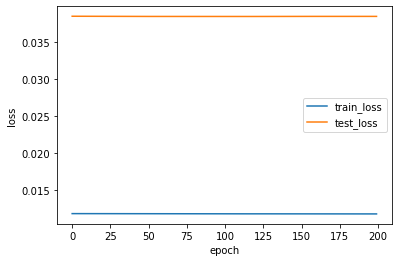

In [26]:
#绘制loss曲线
x=np.arange(num_epochs)
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

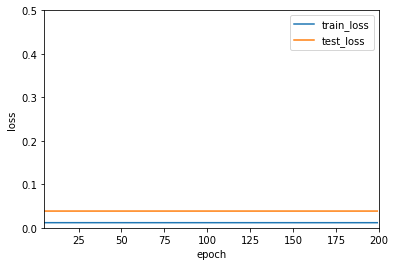

In [28]:
#绘制局部loss曲线
x=np.arange(num_epochs)
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.xlim(5,num_epochs)
plt.ylim(0,0.5)
plt.show()

In [29]:
#预测函数，利用训练好的网络在测试集上进行测试、评估
def predict(x):
    temp=torch.from_numpy(x)
    x_tensor=temp.reshape(1,1,window_size-1)
    return net(x_tensor)

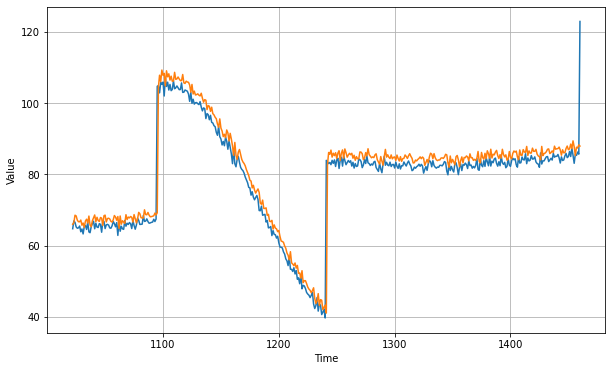

In [31]:
test_predict=[]
split_point=int(split_prop*int(series.size))
for i in range((split_point-(window_size-1)),(series.size-window_size+1)):
    x=series[i:i+window_size-1]
    y=predict(x)
    test_predict.append(y)
test_time=time[split_point:]
plt.figure(figsize=(10,6))
plot_series(test_time,test)
plot_series(test_time,test_predict)
plt.show()